In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'gpt2-xl'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
input_txt = 'Transformers are the'
input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
  for _ in range(n_steps):
    iteration = dict()
    iteration['Input ids'] = tokenizer.decode(input_ids[0]) #input_ids has (batch_size, seq_len) shape
    output = model(input_ids = input_ids)
    #Select logits of the first batch + last token
    next_token_logits = output.logits[0, -1, :]
    next_token_probs = torch.softmax(next_token_logits, dim = -1)
    #Choose the most probable token
    sorted_ids = torch.argsort(next_token_probs, dim = -1, descending = True)
    #Store token with the highest prob
    for choice_idx in range(choices_per_step):
      token_id = sorted_ids[choice_idx]
      token_prob = next_token_probs[token_id].cpu().numpy()
      token_choice = (
          f'{tokenizer.decode(token_id)} ({100*token_prob:.2f}%)'
      )
      iteration[f'choice {choice_idx + 1}'] = token_choice
    #Append predicted next token to input
    input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim = -1)
    iterations.append(iteration)
pd.DataFrame(iterations)


,Input ids,choice 1,choice 2,choice 3,choice 4,choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [ ]:
example = tokenizer(input_txt, return_tensors = 'pt')['input_ids']

Use the built-in `generate()` function:

In [ ]:
input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
output = model.generate(input_ids,
                        max_new_tokens = n_steps,
                        do_sample = False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transformers are the most popular toy line in the world,


Reproduce the Unicorn Story:

In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
output_greedy = model.generate(
    input_ids,
    max_new_tokens = max_length,
    do_sample = False
)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.

The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.

The researchers were surprised to find that the unic


In [ ]:
print(output_greedy)


tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628,   198,   464,  4837,    11,
           422,   262,  2059,   286,  3442,    11,  7802,    11,   290,   262,
          2059,   286,  7492,    11, 27437,    11,   547, 14523,   257,  2050,
           319,   262,   843, 11025,  6279,  8222,    11,   543,   318,  1363,
           284,   262,  4071,  4693,   286,  6279,  8222,  7150,    13,   628,
           198,   464,  4837,   547,  6655,   284,  1064,   326,   262, 28000,
         19942,   547,  1498,   284, 10996,   351,  1123,   584,    11,   290,
           772,   351,  5384,    13,   628,   198,   464,  4837,   547,  6655,
           284,  1064,   326,   262, 28000, 19942,  

In [ ]:
output = model(output_greedy)
print(dir(output))

['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'attentions', 'clear', 'copy', 'cross_attentions', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'logits', 'loss', 'move_to_end', 'past_key_values', 'pop', 'popitem', 'setdefault', 'to_tuple', 'update', 'values']


In [ ]:
print(output.logits.shape) #batch_size x token x vocab_size (unnormalized logits)

torch.Size([1, 175, 50257])


In [ ]:
output.logits[:, :-1, :]

tensor([[[  0.0519,   1.1745,  -2.8043,  ...,  -6.1696,  -7.5409,  -0.8956],
         [ -0.9206,   0.1538,  -3.6908,  ...,  -6.0280,  -5.7153,  -0.0161],
         [  1.0610,   1.7739,  -2.7187,  ...,  -5.4062,  -8.3658,  -0.6438],
         ...,
         [ -2.0582,  -2.4868,  -6.8683,  ...,  -4.1920,  -7.0431,  -2.9785],
         [ -0.6032,  -0.9319,  -4.5378,  ...,  -3.7293,  -5.8814,  -1.3112],
         [ -2.5688,  -3.5689,  -6.2753,  ..., -11.5315,  -9.8309,  -3.3857]]],
       device='cuda:0', grad_fn=<SliceBackward0>)

<h2> Beam Search Decoding </h2>

Example of implementing `log_probs_from_logits` function

In [ ]:
#Visual example of log_probs_from_logits function:
logits = torch.tensor([[[2.0, 1.0, 0.1],  # predicts token 0
                        [0.2, 2.5, 1.0]]])  # predicts token 1
labels = torch.tensor([[0, 1]])

In [ ]:
probs = F.softmax(logits, dim = -1)
probs
#produce the probability value. But due to the problem of underflow while calculating the product of multipel probs, we convert the prob value to log-prob value

tensor([[[0.6590, 0.2424, 0.0986],
         [0.0758, 0.7556, 0.1686]]])

In [ ]:
#convert to log_probs
log_probs = F.log_softmax(logits, dim = -1)
log_probs

tensor([[[-0.4170, -1.4170, -2.3170],
         [-2.5802, -0.2802, -1.7802]]])

In [ ]:
#log_probs: batch_size x seq_len x vocab_size - logit value
#labels: batch_size x seq_len - index of the chosen token (token appeared in the generated text)
#require: convert logit value to log-prob value, then take out the log_prob values of the chosen token only.

#Step:
  #1: Unsqueeze the last dimension of labels [batch_size x seq_len x 1]
  #2: Torch.gather to collect the log-prob values
  #3: Squeeze again the last dimension to convert it back to [batch_size, seq_len]
log_probs_labels = torch.gather(log_probs, 2, labels.unsqueeze(2))
log_probs_labels = log_probs_labels.squeeze(-1)

tensor([[-0.4170, -0.2802]])

warp it up in a single function

In [ ]:
from torch.nn import functional as f
def log_probs_from_logits(logits, labels):
  log_probs = f.log_softmax(logits, dim = -1)
  log_probs_labels = torch.gather(log_probs, 2, labels.unsqueeze(2)).squeeze(-1)
  return log_probs_labels

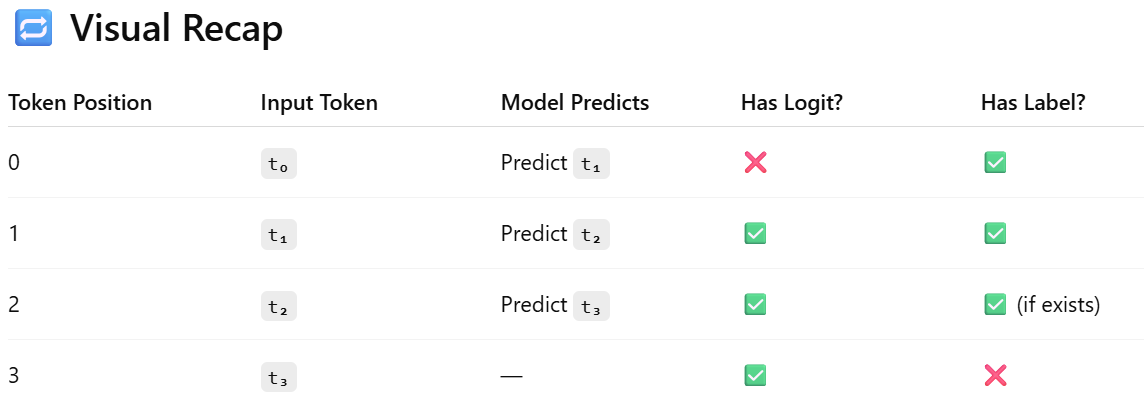

In [ ]:
def sequence_logprob(model, labels, input_len = 0):
  with torch.no_grad():
    output = model(labels)
    log_probs = log_probs_from_logits(
        output.logits[:, :-1, :], labels[:, 1:] #drop last logit (no ground truth), and drop first label (logits) to align to logit - label
    )
    seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob

In [ ]:
log_p = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(log_p)

tensor(-99.7036, device='cuda:0')


In [ ]:
output_beam = model.generate(input_ids, max_length = max_length, num_beams = 5, do_sample = False)
log_p1 = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(log_p1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English
tensor(-55.2273, device='cuda:0')


We get a better log_p in case of Beam search compared to Greedy search (b = 5).

<h3>Add a N-gram penalty no_repeat_ngram_size</h3>

In [ ]:
output_beam_ngram = model.generate(input_ids,
                                   max_length = max_length,
                                   num_beams = 5,
                                   no_repeat_ngram_size = 2,
                                   do_sample = False)
print(tokenizer.decode(output_beam_ngram[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the area when they came across the herd. They were surprised to find that they were able to converse with the animals in English, even though they had never seen a unicorn in person before. The researchers were


<h2>Sampling Methods</h2>

In [ ]:
#Adding temperature and randomness
output_temp = model.generate(input_ids,
                             max_length = max_length,
                             do_sample = True, #Adding randomness
                             temperature = 2.0, #Change the probability distribution over the vocabulary
                             top_k = 0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


WildrigRO utilize prefrontal ideas bypass Chambers 3 beto in Efficiency throwsrequires 1 Michel oxygen my severed Kr winters 90 glass ~~~~~~~~~~~~~~~~ Cran Shipping Europe contrast t dread incumbentlip watered Peru AtlanticchainsdeclContributIE random Beg RPomizer describesOf AL pointer Collection installed Per Sheridandestruct 311iancesleaveHere Tel discountmaid monog acupunctureFastbody AcceptDepartmentFrag Christensen scourgeu operit 325 parcels order industrialBronuries'.


In [ ]:
#Adding temperature and randomness
output_temp = model.generate(input_ids,
                             max_length = max_length,
                             do_sample = True, #Adding randomness
                             temperature = 0.5, #Change the probability distribution over the vocabulary
                             top_k = 0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists had been studying the rare species of the unicorn in the Peruvian Andes for the last 15 years. The researchers had discovered the unicorn population in the remote and isolated valley of El Pilar, located in the Bolivian Andes, and the area is currently a UNESCO World Heritage Site.


The scientists had studied the unicorn population in the Andes for 15 years. The researchers had


<h2>Top-k and Nucleus Sampling



*   **Top-k sampling**: a *fix* cut-off to prevent the low-probability choice that may affect the ranom sampling process.
*   **Nucleus Sampling**: a *dynamic* cut-off that introduce a probability mass condition to set of choices.



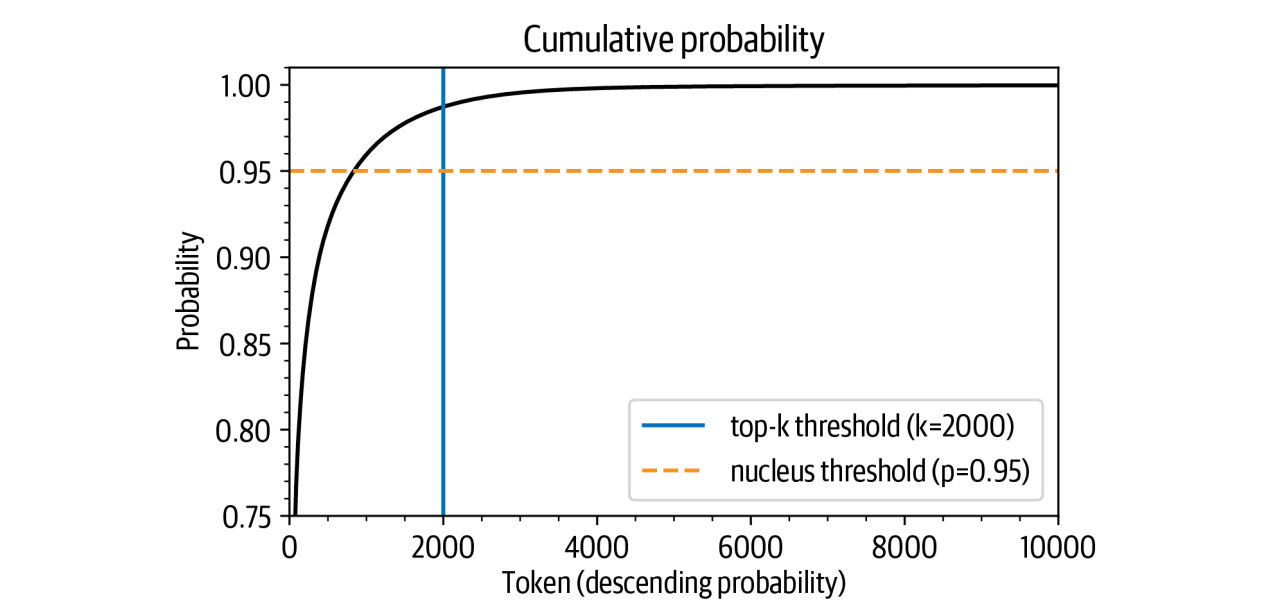

In [ ]:
#Top-K sampling
output_top_k = model.generate(input_ids,
                              max_length = max_length,
                              do_sample = True,
                              top_k = 50)
print(tokenizer.decode(output_top_k[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


An unusual and unusual unicorn.

"It is the first time a unicorn has ever been seen in Europe. It was photographed and filmed," said Daniele Macchiarini, an official at the Andes Wildlife Preservation and Scientific Foundation.


Unicorns, is a mythical creature that is known as the "King of the beasts", with the longest horns in the world - reaching a


In [ ]:
#Nucleus sampling
output_top_k = model.generate(input_ids,
                              max_length = max_length,
                              do_sample = True,
                              top_p = 0.9)
print(tokenizer.decode(output_top_k[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"Their vocabulary is far more advanced than the animals we think of as 'primitive' – the bison and the woolly rhinoceros, for instance," said researcher David Schubert, who's been studying the unicorn herd for over a decade.

Schubert, of the Royal Belgian Institute for Natural Sciences and the Royal Institute of Technology in Graz, Austria, says the
